In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.datasets import mnist, cifar10
from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from itertools import cycle
import itertools


In [4]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [5]:
LABELS = { 0:'A',  1:'B',  2:'C',  3:'D',  4:'E',  5:'F',  6:'G',  7:'H',  8:'I',  9:'K', 
          10:'L', 11:'M', 12:'N', 13:'O', 14:'P', 15:'Q', 16:'R', 17:'S', 18:'T', 19:'U', 
          20:'V', 21:'W', 22:'X', 23:'Y'}

In [6]:
def cross_entropy(y, o):
    return - np.sum(y * np.log10(o + 1e-10))

def errors(targets, predictions, y_test_cat, probabilities, n=10):
    header = ['img_index', 'loss', 'true', 'true_prob', 'predicted', 'predicted_prob']
    errors_df = pd.DataFrame()
    for idx, (tgs, prd) in enumerate(zip(targets, predictions)):
        if tgs != prd:
            errors_df = errors_df.append(pd.Series([idx, 
                                                    cross_entropy(y_test_cat[idx], probabilities[idx]),
                                                    tgs,
                                                    probabilities[idx][tgs],
                                                    prd,
                                                    probabilities[idx][prd]]), 
                                         ignore_index=True)
    errors_df.columns = header
    result = errors_df.sort_values('loss', ascending=False)
    print("Theres were {}, misclassifications.".format(len(result)))
    return result.head(n)

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [7]:
train_df = pd.read_csv('sign_mnist_train.csv')
print(train_df.head())
test_df  = pd.read_csv('sign_mnist_test.csv')
print(test_df.head())
x_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]
print(np.unique(y_train))
x_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]
print(np.unique(y_test))
for index, value in enumerate(y_train):
    if value >= 10:
        y_train[index] = value - 1
for index, value in enumerate(y_test):
    if value >= 10:
        y_test[index] = value - 1
print(np.unique(y_train))
print(np.unique(y_test))

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9    ...     pixel775  pixel776  pixel777  pixel778  pixel779  \
0     153    ...          207       207       207       207       206   
1     158    ...           69       149       128        87        94   
2     187    ...          202       201       200       199       198   
3     210    ...          235       234       233       231       230   
4     185    ...           92       105       105       108       133   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0       206       206       204       203       20

In [8]:
inputs = Input(shape=(784,))
f = Dense(400, activation='relu')(inputs)
f = Dense(200, activation='relu')(f)
f = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01))(f)
f = Dense(100, activation='relu')(f)
f = Dense( 50, activation='relu', kernel_regularizer=regularizers.l2(0.01))(f)
f = Dropout(0.1)(f)
outputs = Dense(24, activation='softmax')(f)
model = Model(inputs=inputs, outputs=outputs)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
__________

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train / 255, 
                    y=to_categorical(y_train.values, num_classes=24), 
                    batch_size=128, epochs=20, 
                    validation_split=0.2)

Train on 21964 samples, validate on 5491 samples
Epoch 1/20
21964/21964 [==============================] - 5s 211us/step - loss: 3.4816 - acc: 0.1497 - val_loss: 2.4862 - val_acc: 0.2453
Epoch 2/20
21964/21964 [==============================] - 3s 121us/step - loss: 2.1634 - acc: 0.3367 - val_loss: 1.8641 - val_acc: 0.4420
Epoch 3/20
21964/21964 [==============================] - 2s 105us/step - loss: 1.7668 - acc: 0.4593 - val_loss: 1.6398 - val_acc: 0.5216
Epoch 4/20
21964/21964 [==============================] - 3s 122us/step - loss: 1.5047 - acc: 0.5468 - val_loss: 1.2593 - val_acc: 0.6347
Epoch 5/20
21964/21964 [==============================] - 3s 126us/step - loss: 1.2638 - acc: 0.6304 - val_loss: 1.1768 - val_acc: 0.6649
Epoch 6/20
21964/21964 [==============================] - 3s 125us/step - loss: 1.0767 - acc: 0.6956 - val_loss: 0.9588 - val_acc: 0.7476
Epoch 7/20
21964/21964 [==============================] - 2s 111us/step - loss: 0.9334 - acc: 0.7462 - val_loss: 0.7340 - v

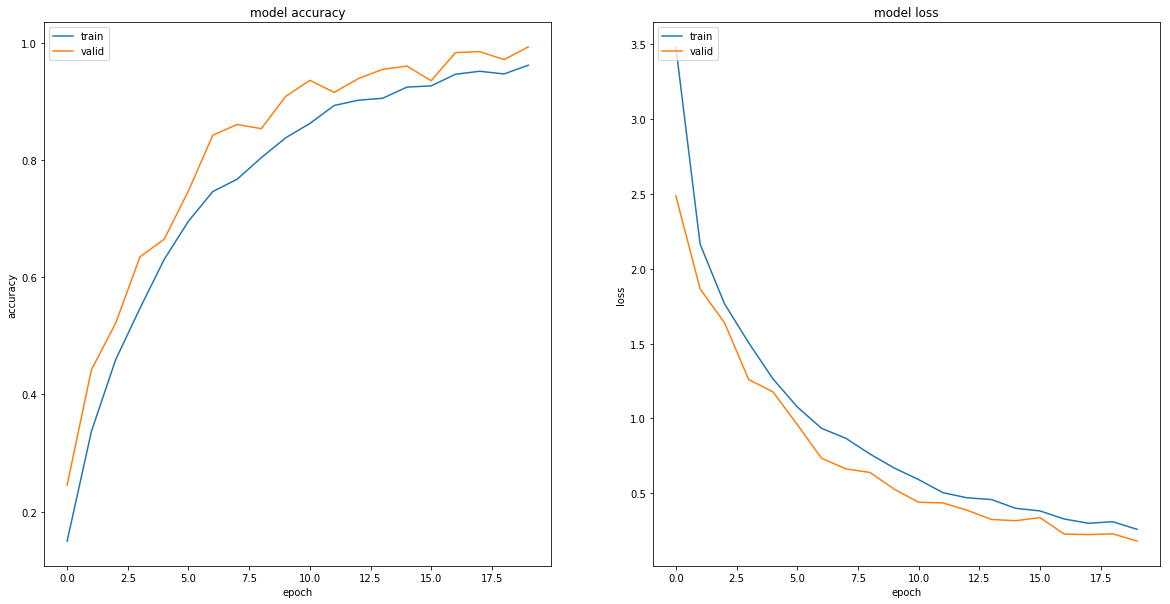

In [11]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

7172/7172 [==============================] - 1s 75us/step
Test Set	Loss : 4.730604		Accuracy :  71.36%


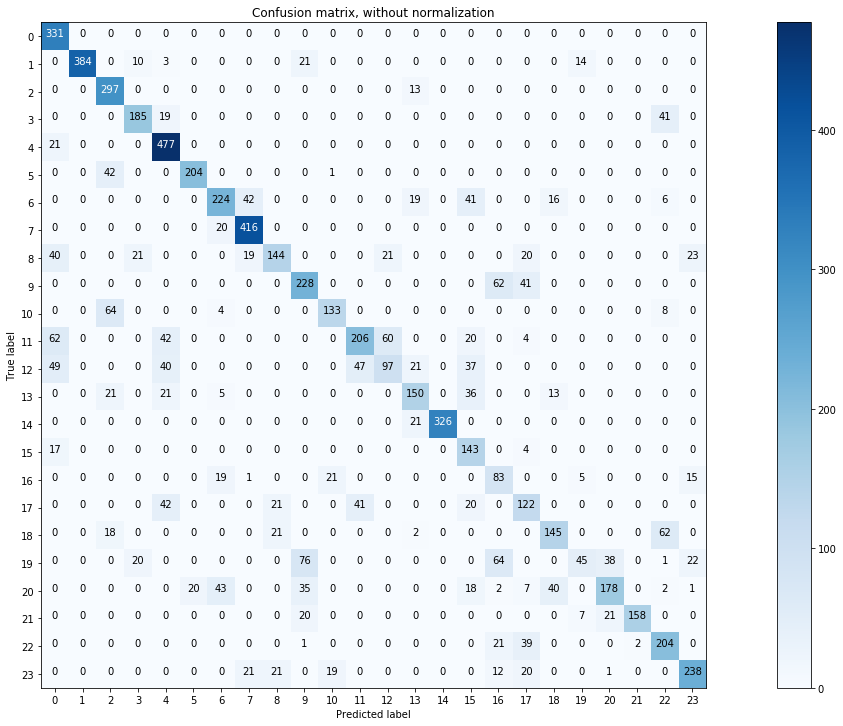

In [12]:
loss, acc = model.evaluate(x=x_test, y=to_categorical(y_test, 24))
print("Test Set\tLoss : {:2f}\t\tAccuracy : {:6.2f}%".format(loss, 100 * acc))
targets = np.argmax(to_categorical(y_test, 24), axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
# print(cm)
classes = np.unique(y_test)
plot_confusion_matrix(cm, classes=classes)

In [13]:
top_errors = errors(targets, predictions, to_categorical(y_test, 24), probabilities, n=10)
print(top_errors)

Theres were 2054, misclassifications.
      img_index  loss  true  true_prob  predicted  predicted_prob
0          12.0  10.0  20.0        0.0        9.0             1.0
1351     4647.0  10.0  13.0        0.0        2.0             1.0
1364     4685.0  10.0  20.0        0.0        9.0             1.0
1363     4684.0  10.0  23.0        0.0       16.0             1.0
1362     4680.0  10.0  22.0        0.0       16.0             1.0
1361     4679.0  10.0  19.0        0.0       16.0             1.0
1360     4672.0  10.0  18.0        0.0       22.0             1.0
1359     4670.0  10.0  12.0        0.0       11.0             1.0
1358     4668.0  10.0  11.0        0.0        0.0             1.0
1357     4667.0  10.0   7.0        0.0        6.0             1.0


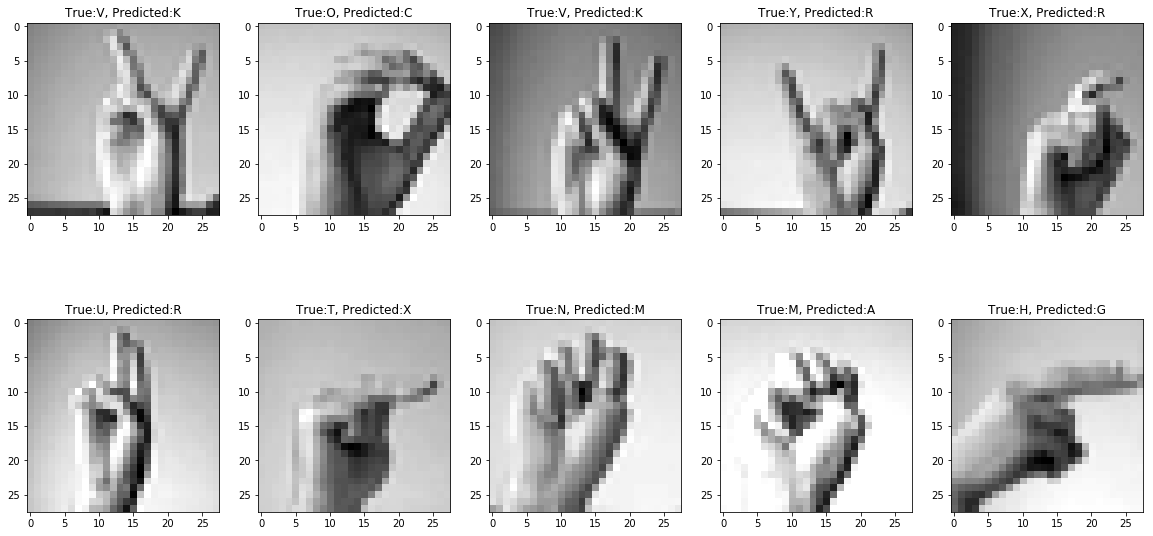

In [14]:
plt.figure(figsize=(20, 10))
for n in range(10):
    plt.subplot(2,5,n+1)
    sample = x_test.iloc[int(top_errors.img_index.iloc[n])].values.reshape(28, -1)
    plt.imshow(sample, cmap='gray')
    plt.title("True:{}, Predicted:{}".format(LABELS[int(top_errors.true.iloc[n])],
                                             LABELS[int(top_errors.predicted.iloc[n])]))
plt.show()

In [16]:
asl_knn = KNN()
asl_knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [17]:
knn_predict = asl_knn.predict(x_test)

In [20]:
100*accuracy_score(y_test, knn_predict)

80.59118795315115